# Transfer Learning

## Introduction to transfer learning

Transfer learning is a technique that allows you take a neural network that has been already trained of one of these very large datasets, and tweak it slightly to adapt it to a new dataset.

Advantages:
- far less data needed then when starting from scratch
- saves a lot of time and experimenting
- makes use of a pre-designed and pre-trained architecture instead

Identify does nothing: input is the same as the output

## Skip connection

ResNet is a very important architecture that introduced a fundamental innovation: the skip connection.

See below some example code on how to implement the skip connection:
```python
class ResidualBlock(nn.Module):
    def __init__(self, inp, out1, out2):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(inp, out1, 3),
            nn.ReLU(),
            nn.Conv2d(out1, out2, 3)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # F(x)
        F = self.conv_block(x)
        # IMPORTANT BIT: we sum the result of the
        # convolutions to the input image
        H = F + x
        # Now we apply ReLU and return
        return self.relu(H)
```

## Global Average Pooling (GAP) Layer

- instead of taking the last feature maps and flattening them into a long vector, GAP takes the average of each feature map and place them in a much shorter vector


## Attention layers
The concept of attention is a very important concept in modern neural networks. It is a simple idea: the network should learn to boost some information that is helpful for a given example, and decrease the importance of information that is not useful for that example.
- so, some feature maps are more important than others

There are several forms of attention. Let's look at two important ones.

### Channel Attention: Squeeze and Excitation (SE)
Computes a scale factor for each input feature map and then multiply each feature map by its scale factor, boosting important feature maps:
- adds a sub-network that given the feature maps/channels assigns a scale to each input feature map.
  
### Vision Transformers (self-attention)
In short, the image is divided in patches, the patches are transformed into embedded representations, and these representations are fed to a Transformer that treats them as a sequence.
- Learns the relationship of each patch of the image with every other patch

## State of the art Computer Vision models

- Pure CNNs:
  - based on convolution, max pooling, channel attention
  - are more data-efficient because of local connectivity (pixels close to each other are related), and weight sharing
  - examples: EfficientNet V2, ConvNeXt
- Pure Transformers:
  - based on self-attention
  - are more general, but need more data to learn
  - examples: ViT, Swin transformer
- Hybrid architectures:
  - mix elements of CNNs with elements of Transformers
  - examples: CoatNet

## Transfer Learning

Transfer learning is a technique that allows us to re-use what a network has learned on one dataset to learn about a different dataset.

One technique is to:
-  **keep the initial layers (that are pretty universal) unchanged** or almost unchanged, while we change the last layers that must be specialized by task
  - these initial layers only extract elementary features such as edges, colors and can be applied on other data sets

**Workflow** of transfer learning:
-  take a pre-trained model
-  freezing some of the initial layers and freeing or substituting some late layers
-  and then train on our dataset

Torchvision has a lot of pre-trained networks. To get them, use the code below as an example:
```python
import torchvision.models
model = torchvision.models.resnet18(pretrained=True)
```

**Frozen parameter** =  a parameter that is not allowed to vary during training. In other words, backpropagation will ignore that parameter and won't change its value nor compute the gradient of the loss with respect to that parameter.

To freeze all parameters of a certain (`fc`) layer, use this code in PyTorch:
```python
for param in model.fc.parameters():
  param.requires_grad = False
```

For a BatchNorm layer this is slightly different, to use the full layer we need to use: `model.bn.eval()` instead. This is not the same as `model.eval()`, which would put the entire model into evaluation mode.

To understand which layers to freeze we have to know the architecture. Don't use `print(model)` for this since this does not necessarily correspond to the `forward` method. Instead, use the `Netron` app.

### Transfer learning strategies

There are multiple strategies based on (1) the size of your dataset and (2) how similar the data is:

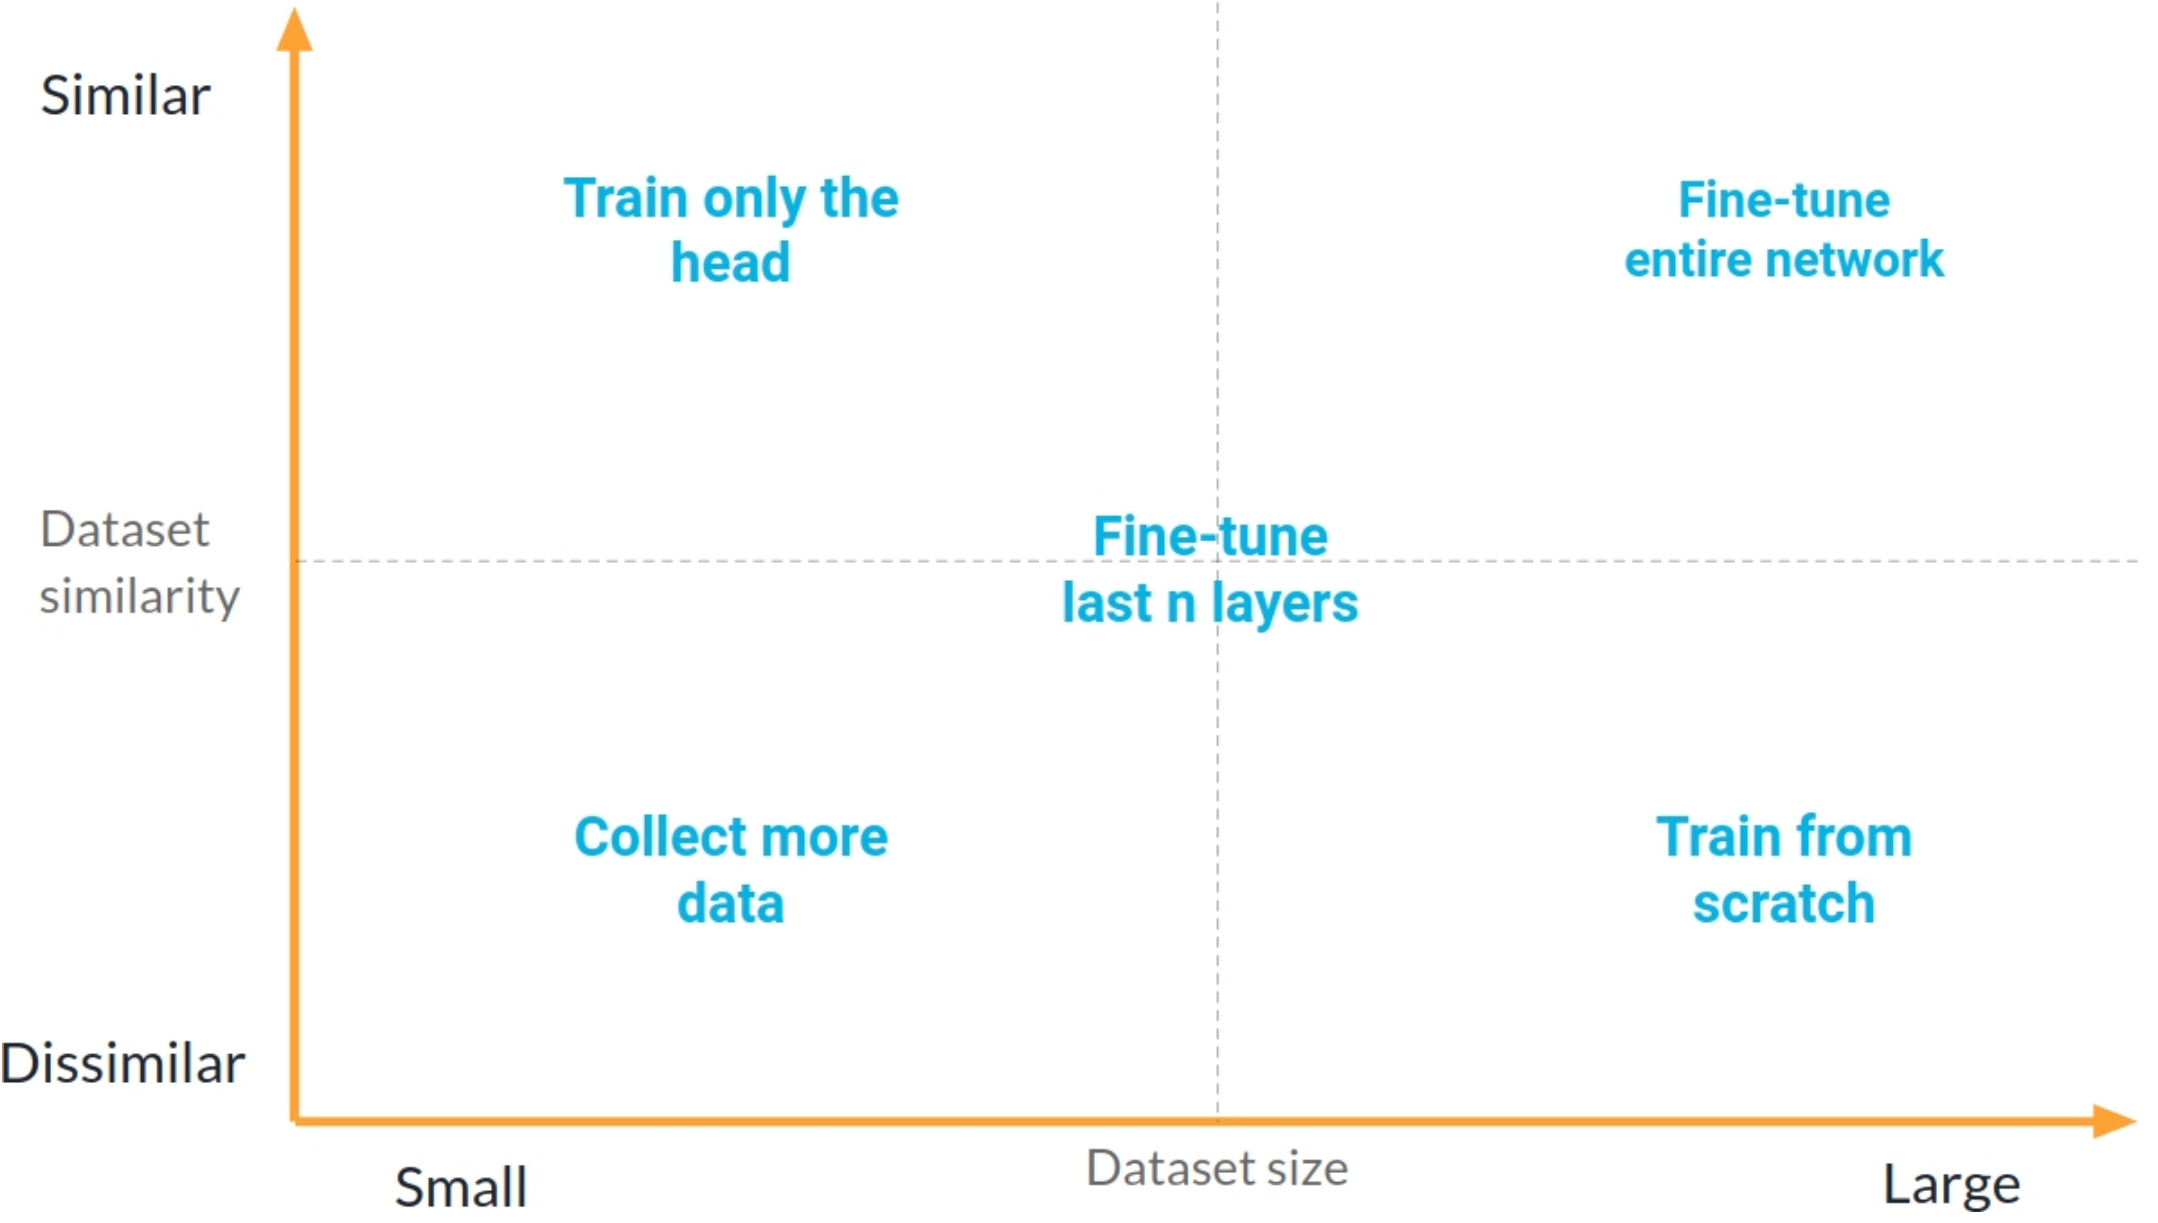

### Example of tranfer learning

Example in PyTorch:
```python
import torch.nn as nn
import torchvision.models

## Get a pre-trained model from torchvision, for example
## ResNet18
model = torchvision.models.resnet18(pretrained=True)

## Let's freeze all the parameters in the pre-trained
## network
for param in model.parameters():
    param.requires_grad = False

## Through Netron.app we have discovered that the last layer is called
## "fc" (for "fully-connected"). Let's find out how many input features
## it has
input_features = model.fc.in_features
## We have 10 classes
n_classes = 10
## Let's substitute the existing fully-connected last layer with our
## own (this will have all its parameters free to vary)
model.fc = nn.Linear(input_features, n_classes)
## or we can use a more complicated head (this might or might not
## lead to improved performances depending on the case)
model.fc = nn.Sequential(
    nn.BatchNorm1d(input_features),
    nn.Linear(input_features, input_features * 2),
    nn.ReLU(),
    nn.BatchNorm1d(input_features * 2),
    nn.Dropout(0.5),
    nn.Linear(input_features * 2, n_classes)
)
```


## Visualising CNNs

Resources for visualisation of CNNs:
- https://poloclub.github.io/cnn-explainer/
- https://github.com/jacobgil/pytorch-grad-cam
- https://www.youtube.com/watch?v=AgkfIQ4IGaM&t=78s
- Read [this Keras blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) on visualizing how CNNs see the world. In this post, you can find an accessible introduction to Deep Dreams. When you've read that:
  - Also check out [this music video](https://www.youtube.com/watch?v=XatXy6ZhKZw) that makes use of Deep Dreams (look at 3:15-3:40)!

## Glossary

Skip connection: An innovation of ResNet, this is a path in a network allowing it to jump a layer if needed.

Global Average Pooling (GAP) layer: A type of pooling equivalent to Average Pooling, but with the average taken over the entire feature map. It is equivalent to an Average Pooling layer with the window size equal to the input size.

Channel Attention (Squeeze-and-excitation, or SE, block): A little network-in-network that allows the model to pay more attention to some feature maps that are more useful than others to classify a specific image.

Self Attention: A mechanism alternative to convolution+pooling and characteristic of the Transformers architecture. It allows the model to directly learn the relationship between different parts of the image and use it to solve the task at hand (e.g., image classification).

Transfer learning: A set of techniques that allow to re-use what a network has learned from a dataset on a different dataset. It allows us to get very good performances much more quickly, and on smaller datasets, than training from scratch.

Frozen parameter: A parameter that is not allowed to vary during training.

## Misc

- 16 layers in a CNN = 16 channels = 16 feature maps = 16 filters
- The term "channel" can refer to the channels in the input image (3 channels if RGB) but also to the number of feature maps are output from a layer.
- Train until convergence = until the validation loss stops decreasing